In [1]:
import underworld as uw
import glucifer
import numpy as np

In [223]:
# create periodic mesh
mesh = uw.mesh.FeMesh_Cartesian(minCoord=(-1,-1), maxCoord=(1,1), periodic=(True,False))

In [224]:
velocity = uw.mesh.MeshVariable(mesh, 2)

In [225]:
# setup shear
velocity.data[:] = (0.,0.)
velocity.data[:,0] = 2.*mesh.data[:,1]


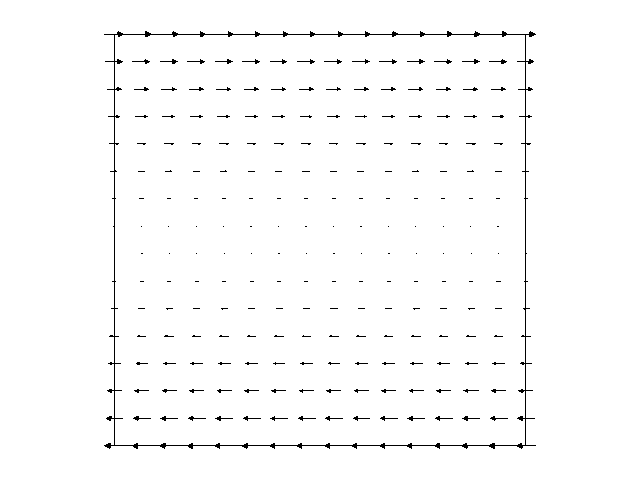

In [226]:
fig = glucifer.Figure()
fig.append( glucifer.objects.VectorArrows(mesh,velocity, scaling=0.05))
fig.show()

In [227]:
swarm = uw.swarm.Swarm(mesh)
normal = swarm.add_variable('double',2)
swarm.populate_using_layout(uw.swarm.layouts.GlobalSpaceFillerLayout(swarm,20))

In [228]:
fig.append(glucifer.objects.Points(swarm,pointSize=3., pointType=1, colourBar=False))


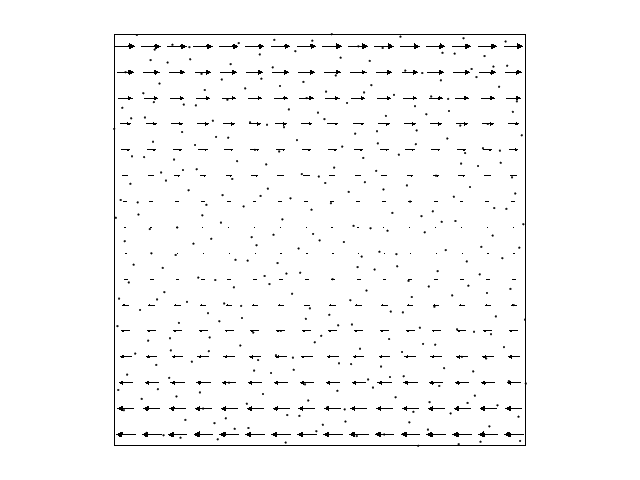

In [229]:
fig.show()

In [230]:
# initialise to point upwards
normal.data[:] = (0.,1.)

In [231]:
# cast to mesh so we can see
cast_var = uw.mesh.MeshVariable(mesh,2)
cast = uw.utils.MeshVariable_Projection(cast_var,normal)

In [232]:
# viz 
normal_fig = glucifer.Figure()
normal_fig.append(glucifer.objects.VectorArrows(mesh,cast_var,scaling=0.001))


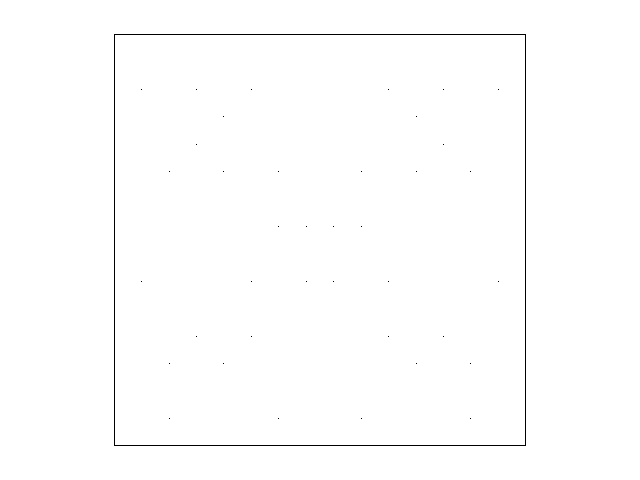

In [233]:
cast.solve()
normal_fig.show()

In [234]:
# just use advector system to get some reasonable dt
advector = uw.systems.SwarmAdvector(velocity,swarm)
dt = advector.get_max_dt()
# dt = 0.05

In [235]:
# get grad on all particles.. particles are not moving, and velocity is fixed, so only need to do this once.
velgrad = velocity.fn_gradient.evaluate(swarm)
velgrad[0]

array([ 0.,  2.,  0.,  0.])

In [236]:
#rotate the velocity field



In [237]:
from underworld import function as fn

strainRateFn = fn.tensor.symmetric( velocity.fn_gradient )

strainRateFn.evaluate(mesh)[0]

array([ 0.,  0.,  1.])

In [238]:
time = 0.
maxtime = 100.
while time<maxtime:
    # expected angle
    angle = 0.5 * np.pi - np.arctan2(1.,2.*time)
    # director angles
    angleDirector = np.arctan2(-normal.data[:,1],normal.data[:,0])
    # angle errors
    angleError = angle - angleDirector

    # calculate $\dot n_i_orth  = -L_{ji} n_j$, (this operates on teh director - i.e orthogonal to the material element)
    #n_dot_x = -(velgrad[:,0]*normal.data[:,0] + velgrad[:,2]*normal.data[:,1])
    #n_dot_y = -(velgrad[:,1]*normal.data[:,0] + velgrad[:,3]*normal.data[:,1])
    
    # calculate $\dot n_i = L_{ji} n_j$
    n_dot_x = (velgrad[:,0]*normal.data[:,0] + velgrad[:,1]*normal.data[:,1])
    n_dot_y = (velgrad[:,2]*normal.data[:,0] + velgrad[:,3]*normal.data[:,1])
    # apply forward euler
    normal.data[:,0] += dt*n_dot_x
    normal.data[:,1] += dt*n_dot_y

    time += dt
    
    # check if any angles not as expected
    #if (np.abs(angleError) > 1e-15).any():
    #    raise RuntimeError("Director test failed.")


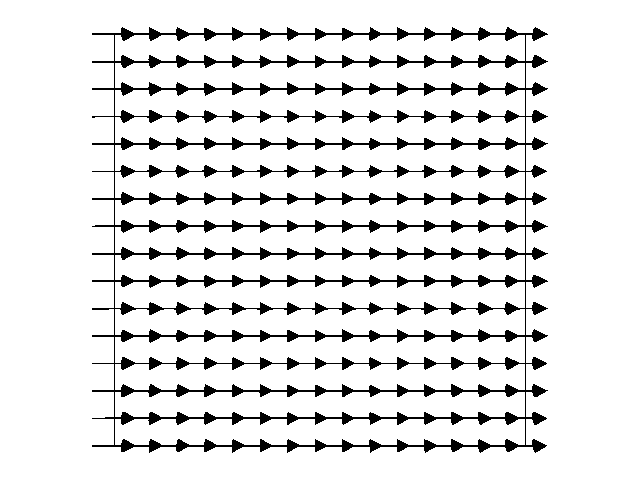

In [239]:
cast.solve()
normal_fig.show()

In [240]:
sRt[0,2]

0.0

In [241]:
eig1       = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=2 )

sRt = strainRateFn.evaluate(mesh)

tau = np.sqrt(((sRt[:,0]+ 1e-14 - sRt[:,1])**2)/4. + sRt[:,2]**2) #shear stress max.
principalAngles = 0.5*np.arcsin(sRt[:,2]/tau)


#eig1.data[:,0] = np.cos(np.radians(principalAngles))
#eig1.data[:,1] = np.sin(np.radians(principalAngles))

eig1.data[:,0] = np.cos(principalAngles)
eig1.data[:,1] = np.sin(principalAngles)

In [242]:
np.degrees(principalAngles)

array([ 45.,  45.,  45.,  45.,  45.,  45.,  45.,  45.,  45.,  45.,  45.,
        45.,  45.,  45.,  45.,  45.,  45.,  45.,  45.,  45.,  45.,  45.,
        45.,  45.,  45.])


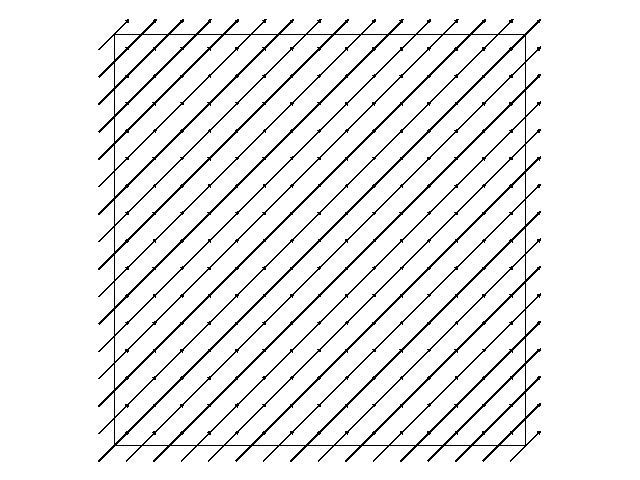

In [243]:
fig = glucifer.Figure()
fig.append( glucifer.objects.VectorArrows(mesh,eig1, scaling=0.2,arrowHead=0.1))
fig.show()

In [244]:
#Set up a swarm Stress function

#swarmStressFn = 2.*stokesPIC.fn_viscosity*strainRate_2ndInvariant


# In[78]:

sym_strainRate = fn.tensor.symmetric( 
                            velocity.fn_gradient )


eig1       = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=2 )

eig2       = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=2 )


#meshVisc = uw.mesh.MeshVariable( mesh, 1)
#projectGuy = uw.utils.MeshVariable_Projection(meshVisc, viscosityMapFn, type=0 )
#projectGuy.solve() 


# In[79]:

ssr = sym_strainRate.evaluate(mesh)


for ti, val in enumerate(eig1.data):
    eigVals, eigVex= np.linalg.eigh(np.array([[ssr[ti][0],ssr[ti][2]],[ssr[ti][2],ssr[ti][1]]]), UPLO='U')
    #eig1.data[ti] = meshVisc.data[ti]*eigVals[0]*eigVex[0]
    #eig2.data[ti] = meshVisc.data[ti]*eigVals[1]*eigVex[1]
    eig1.data[ti] = eigVex[0]
    eig2.data[ti] = eigVex[1]

In [245]:
eigVals

array([-1.,  1.])

## SOLx solution

In [8]:
import underworld as uw
import glucifer
import numpy as np
from underworld import function as fn


In [9]:
meshX = 64
meshY = 64

In [10]:
mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q2/dQ1"), 
                                 elementRes  = (meshX, meshY), 
                                 minCoord    = (0., 0.), 
                                 maxCoord    = (1., 1.))

velocityField = uw.mesh.MeshVariable(mesh,2)
pressureField = uw.mesh.MeshVariable(mesh.subMesh,1)

In [20]:

#solA = fn.analytic.

In [51]:

solA = fn.analytic.SolNL(n=2)

In [52]:
vel=solA.fn_velocity
velocityField.data[:] = vel.evaluate(mesh.data)
pressureField.data[:] = 0.


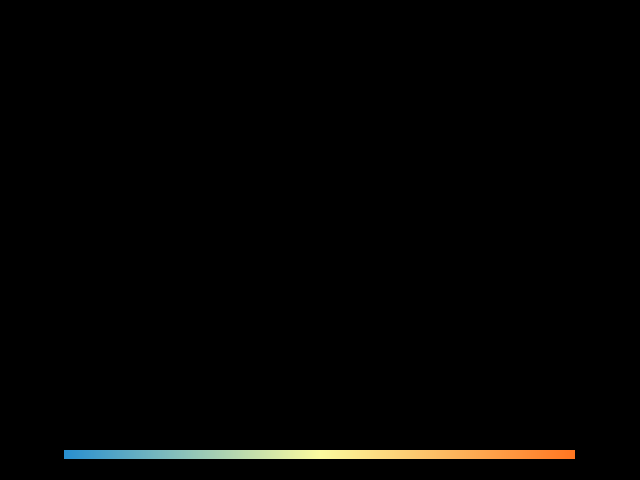

In [53]:
force = glucifer.Figure()
force.append( glucifer.objects.Surface(mesh, fn.math.dot(solA.fn_bodyforce,solA.fn_bodyforce) ) )
force.append( glucifer.objects.VectorArrows(mesh, solA.fn_bodyforce/10.) )
force.show()

In [54]:
strainRateFn = fn.tensor.symmetric( velocityField.fn_gradient )
sRt = strainRateFn.evaluate(mesh)


In [55]:
pS       = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=2 )


tau = np.sqrt(((sRt[:,0]+ 1e-14 - sRt[:,1])**2)/4. + sRt[:,2]**2) #shear stress max.
principalAngles = 0.5*np.arcsin(sRt[:,2]/tau)

#principalAngles = 0.5*np.arctan(2.*sRt[:,2]/(sRt[:,0]+ 1e-14 - sRt[:,1]))


pS.data[:,0] = np.cos(principalAngles)
pS.data[:,1] = np.sin(principalAngles)

In [56]:
pS.data[:,1] 

array([  4.64114760e-05,   4.64107653e-05,   4.64114760e-05, ...,
        -4.64114760e-05,  -4.64107653e-05,  -4.64114704e-05])

In [57]:
#Set up a swarm Stress function




eig1       = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=2 )
eig2       = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=2 )


for ti, val in enumerate(eig1.data):
    eigVals, eigVex= np.linalg.eig(np.array([[sRt[ti][0],sRt[ti][2]],[sRt[ti][2],sRt[ti][1]]]))
    pi = np.argmax(eigVals) #index of largest eigenvalue
    eig1.data[ti] = eigVex[pi]
    eig2.data[ti] = eigVex[abs(pi - 1)] #index of other eigenvalue - 2D assumption


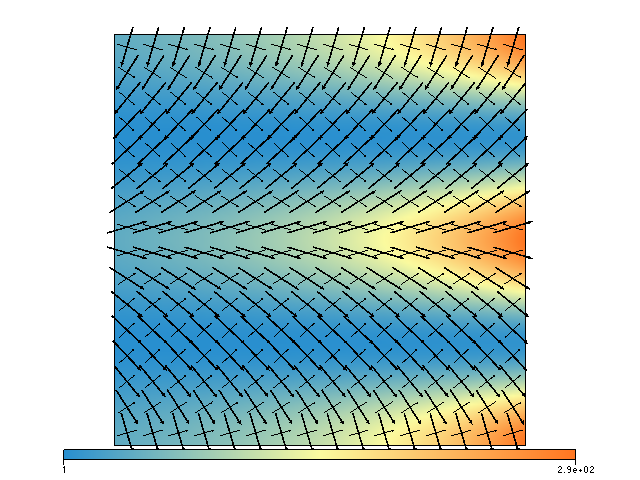

In [60]:
force = glucifer.Figure()
force.append( glucifer.objects.Surface(mesh, fn.math.dot(velocityField,velocityField) ) )
force.append( glucifer.objects.VectorArrows(mesh,pS, scaling=0.05,arrowHead=0.1))
force.append( glucifer.objects.VectorArrows(mesh,eig1, scaling=0.1,arrowHead=0.1))
#force.append( glucifer.objects.VectorArrows(mesh,eig2, scaling=0.1,arrowHead=0.1))


force.show()